# Sistema de Recomendação de Bandas

**Nesse projeto irei criar um  sistema de Recomendação de bandas**

<img src="https://i.imgur.com/GnZQBLx.png" />

**Os dado utilizados foram dados aberto da Last.fm** 

Data Set: https://www.upf.edu/web/mtg/lastfm360k 

 **Sempre me perguntei como empresas de streaming de musica fazem para recomendar artistas que através do meu histórico de uso recomendam bandas que eu possa gostar.**

## É isso que eu vou tentar reproduzir nesse Notebook

crédito: https://github.com/beckernick/music_recommender

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
%matplotlib inline



import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
user_data = pd.read_table(r'C:/Users/skite/OneDrive/Documentos/GitHub/Sistema_de_Recomendações/data_sets/usersha1-artmbid-artname-plays_1.tsv',
                          header = None, nrows = 2e7,
                          names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols = ['users', 'artist-name', 'plays'])

In [3]:
user_profiles = pd.read_table(r'C:/Users/skite/OneDrive/Documentos/GitHub/Sistema_de_Recomendações/data_sets/usersha1-profile.tsv',
                          header = None,
                          names = ['users', 'gender', 'age', 'country', 'signup'],
                          usecols = ['users', 'country'])

## Análise exploratória dos dados

*No data set 'user_data' filtrei somente as colunas que juguei necessária para meu sistema de recomendação que são:*

* Users = Id do usuário
* artist-name = Nome do artista
* plays = A quantidade de vezes que aquele usuário escutou aquela banda

In [4]:
user_data.head()

,users,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


In [5]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068777 entries, 0 to 1068776
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   users        1068777 non-null  object
 1   artist-name  1068770 non-null  object
 2   plays        1068777 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.5+ MB


*Aparentimente temo apenas 7 dados faltantes na variável artist-name.* 

In [6]:
user_profiles.head()

,users,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,United States


In [7]:
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359347 entries, 0 to 359346
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   users    359347 non-null  object
 1   country  359347 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


 **<font color=blue> Quais artistas são mais ouvidos no data set da last.fm ?**

In [8]:
user_data_2 = user_data

In [9]:
user_data_2['count'] = 1

In [10]:
graf_user = user_data_2.groupby('artist-name',as_index=False).agg({'count':'sum'})

In [11]:
graf_user_2 = graf_user.sort_values(by='count', ascending=False)
graf_user_2

,artist-name,count
59480,radiohead,4644
70519,the beatles,4640
17435,coldplay,4075
60186,red hot chili peppers,3055
51966,muse,2830
...,...,...
36043,inflabluntahz,1
36044,inflame resolution,1
36046,informant,1
36048,information,1


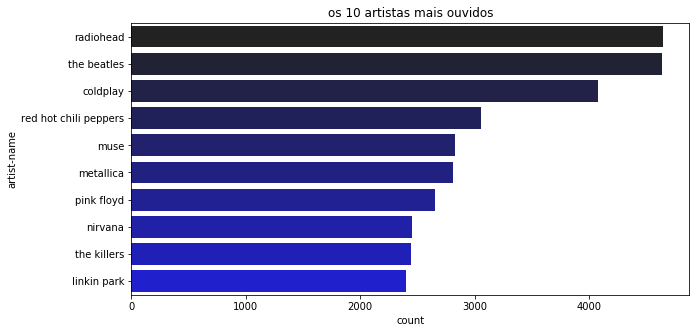

In [12]:
plt.figure(figsize=(10,5))
plt.title("os 10 artistas mais ouvidos")
sns.barplot(x="count", y="artist-name", data=graf_user_2.head(10),  palette=sns.dark_palette ("blue", n_colors=len('artist-name')));

 **<font color=blue>A last.fm é uma ferramenta usada em varios paises**

In [13]:
user_profiles_2 = user_profiles

In [14]:
user_profiles_2['count'] = 1

In [15]:
graf_profiles = user_profiles_2.groupby('country',as_index=False).agg({'count':'sum'})

In [16]:
graf_profiles_2 = graf_profiles.sort_values(by='count', ascending=False)
graf_profiles_2

,country,count
225,United States,67044
79,Germany,31651
224,United Kingdom,29902
170,Poland,20987
176,Russian Federation,19833
...,...,...
131,Marshall Islands,4
77,Gambia,3
118,Liberia,3
22,Benin,3


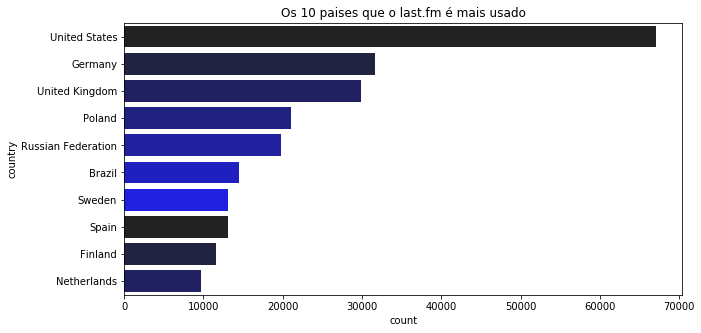

In [17]:
plt.figure(figsize=(10,5))
plt.title("Os 10 paises que o last.fm é mais usado")
sns.barplot(x="count", y="country", data=graf_profiles_2.head(10),  palette=sns.dark_palette ("blue", n_colors=len('country')));

*Ok, agora vamos totalizar a quantidade de plays por artista*

In [18]:
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )

In [19]:
artist_plays.head()

,artist-name,total_artist_plays
0,cours de la somme,9
1,oliver shanti & friends,3
2,!!!,20526
3,!5:b>@ 3070,33
4,!action pact!,226


**Agora vamos fazer um merge dos dados de usuários com o total de cada artista**

In [20]:
user_data_with_artist_plays = user_data.merge(artist_plays, left_on = 'artist-name', right_on = 'artist-name', how = 'left')

In [21]:
user_data_with_artist_plays = user_data_with_artist_plays.drop(['count'], axis='columns')

In [22]:
user_data_with_artist_plays.head()

,users,artist-name,plays,total_artist_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,4242.000
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,194864.000
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,13018.000
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,23194.000
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,7299.000


*Temos agora uma nova coluna com o total de plyas por usuário.*

 **<font color=blue>Vamos verificar as informações de plays por artista**

In [23]:
artist_plays['total_artist_plays'].describe()

count     82875.000
mean       2803.716
std       21421.002
min           1.000
25%          49.000
50%         181.000
75%         725.000
max     1923436.000
Name: total_artist_plays, dtype: float64

*Note que temos uma mádia muito baixa e artistas que tem somente 1 play, provavelmente a grande maioria dos artistas não tem muitas execuções.*

**<font color=blue>Vamos classificar o total de plays**

In [24]:
artist_plays['total_artist_plays'].quantile(np.arange(.9, 1, .01))

0.900    3110.000
0.910    3636.000
0.920    4274.080
0.930    5104.820
0.940    6330.000
0.950    7983.600
0.960   10503.200
0.970   14956.380
0.980   23569.040
0.990   50405.560
Name: total_artist_plays, dtype: float64

## <font color=blue> Filtrando a quantidade minima de plays por artista </font>

*Temos uma grande quantidade de artistas com plays muito baixo, isso pode acabar atrapalhando nosso sistema de recomendação*

*Vamos filtrar o tatal de plays para acima de 50mil plays* 

In [25]:
popularity_threshold = 50000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_popular_artists.head()

,users,artist-name,plays,total_artist_plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,194864.000
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,795958.000
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507,58935.000
12,00000c289a1829a808ac09c00daf10bc3c4e223b,goldfrapp,361,145056.000
17,00000c289a1829a808ac09c00daf10bc3c4e223b,dropkick murphys,302,223162.000


**<font color=blue>Filtrando somente os dados dos Estados Unidos**

*Conforme vimos acima a quantidade de plays nomercado norte americano é muito maior que outros paises*

*Outro fator que foi importante para tomada dessa decisão é que temos uma grande quantidade de artistas do mercado americano e inglês*

In [26]:
combined = user_data_popular_artists.merge(user_profiles, left_on = 'users', right_on = 'users', how = 'left')

In [27]:
pd.options.display.max_rows = 999
combined['country'].value_counts().head(10)

United States         91975
United Kingdom        41819
Germany               37858
Poland                24941
Russian Federation    19917
Sweden                19241
Brazil                18549
Spain                 15965
Finland               15619
Netherlands           12707
Name: country, dtype: int64

In [28]:
usa_data = combined.query('country == \'United States\'')
usa_data = usa_data.drop(['count'], axis='columns')
usa_data.head()

,users,artist-name,plays,total_artist_plays,country
73,00007a47085b9aab8af55f52ec8846ac479ac4fe,devendra banhart,456,152419.000,United States
74,00007a47085b9aab8af55f52ec8846ac479ac4fe,boards of canada,407,366772.000,United States
75,00007a47085b9aab8af55f52ec8846ac479ac4fe,cocorosie,386,158804.000,United States
76,00007a47085b9aab8af55f52ec8846ac479ac4fe,aphex twin,213,256663.000,United States
77,00007a47085b9aab8af55f52ec8846ac479ac4fe,animal collective,203,213856.000,United States


## <font color=blue> Verificando e removendo duplicados </font>

*Nessa etapa vamos verificar se há duplicada de valores repetidos dos usuários por artista*

In [29]:
if not usa_data[usa_data.duplicated(['users', 'artist-name'])].empty:
    initial_rows = usa_data.shape[0]
    
    print('Tamanho incial do data frame {0}'.format(usa_data.shape))
    usa_data = usa_data.drop_duplicates(['users', 'artist-name'])
    current_rows = usa_data.shape[0]
    print('Tamanho do data frame após o filtro {0}'.format(usa_data.shape))
    print('Removidos {0} rows'.format(initial_rows - current_rows))

Tamanho incial do data frame (91975, 5)
Tamanho do data frame após o filtro (91974, 5)
Removidos 1 rows


*Muito bom só tinhamos uma linha druplicada*

## <font color=blue> Formatação corpo (shape) dos Dados </font>

*Para o K-Nearest Neighbors, vamos formatar o`(artist, user)` em um array, em que cada linha é um artista e cada coluna é um usuário. Vamos utilizar o 'pivot' do pandas e incluir '0' nos dados faltantes já que serão executadas operações de álgebra linear (cosine distance) nos dados. Também vamos passar os dados para uma matriz esparsa para que a execução seja mais eficiente.*

In [30]:
wide_artist_data = usa_data.pivot(index = 'artist-name', columns = 'users', values = 'plays').fillna(0)
wide_artist_data.head(20)

users                 00007a47085b9aab8af55f52ec8846ac479ac4fe  \
artist-name                                                      
2pac                                                     0.000   
3 doors down                                             0.000   
30 seconds to mars                                       0.000   
36 crazyfists                                            0.000   
50 cent                                                  0.000   
65daysofstatic                                           0.000   
[unknown]                                                0.000   
a day to remember                                        0.000   
a perfect circle                                         0.000   
a tribe called quest                                     0.000   
a-ha                                                     0.000   
abba                                                     0.000   
ac/dc                                                    0.000   
adam green                                               0.000   
adele                                                    0.000   
aerosmith                                                0.000   
aesop rock                                              72.000   
afi                                                      0.000   
against me!                                              0.000   
agalloch                                                 0.000   

users                 0001a57568309b287363e72dc682e9a170ba6dc2  \
artist-name                                                      
2pac                                                     0.000   
3 doors down                                             0.000   
30 seconds to mars                                       0.000   
36 crazyfists                                            0.000   
50 cent                                                  0.000   
65daysofstatic                                           0.000   
[unknown]                                                0.000   
a day to remember                                        0.000   
a perfect circle                                         0.000   
a tribe called quest                                     0.000   
a-ha                                                     0.000   
abba                                                     0.000   
ac/dc                                                    0.000   
adam green                                               0.000   
adele                                                    0.000   
aerosmith                                                0.000   
aesop rock                                               0.000   
afi                                                      0.000   
against me!                                              0.000   
agalloch                                                 0.000   

users                 00024b5b85c40f990c28644d53257819980bf6bb  \
artist-name                                                      
2pac                                                     0.000   
3 doors down                                             0.000   
30 seconds to mars                                       0.000   
36 crazyfists                                            0.000   
50 cent                                                  0.000   
65daysofstatic                                           0.000   
[unknown]                                                0.000   
a day to remember                                        0.000   
a perfect circle                                         0.000   
a tribe called quest                                     0.000   
a-ha                                                     0.000   
abba                                                     0.000   
ac/dc                                                    0.000   
adam green                                               0.000   
adele                                 

## <font color=blue> Sparse matrices for efficient machine learning </font>


crédito: https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/

*vamos utilizar o metado de  matrizes esparsas para aprendizado de máquina eficiente*

* utilização do 'Compressed Sparse Row matrix

In [31]:
from scipy.sparse import csr_matrix
wide_artist_data_sparse = csr_matrix(wide_artist_data.values)

* salvando e carregando a matriz

In [32]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

save_sparse_csr('lastfm_sparse_artist_matrix.npz', wide_artist_data_sparse)

## <font color=blue> Ajuste do modelo </font>

*vamos utilizar cosine distance como nossa métrica*

In [33]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_artist_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## <font color=blue> Recomendação através de um artista selecionado aleatoriamente </font>

*Finalmente vamos fazer uma recomendação, mas nesse primeiro caso vamos escolher um artista de forma randômica para esse teste* 

In [34]:
# geração do número aleatório
query_index = np.random.choice(wide_artist_data.shape[0])
print(query_index)

# vamos passar os dados para um array, no formato que o modelo espera
vetor = np.array(wide_artist_data.iloc[query_index, :]).reshape(1, -1)

# captura das informações melhores vizinhos com o modelo treinado
distances, indices = model_knn.kneighbors(vetor, n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recomendação para: {0}:\n'.format(wide_artist_data.index[query_index]))
    else:
        print('{0}: {1}, com distância de: {2}:'.format(i, wide_artist_data.index[indices.flatten()[i]], distances.flatten()[i]))

648
Recomendação para: spoon:

1: of montreal, com distância de: 0.6577584155084573:
2: the new pornographers, com distância de: 0.6647031785378086:
3: beck, com distância de: 0.7035773714566428:
4: andrew bird, com distância de: 0.7048726502936575:
5: arcade fire, com distância de: 0.7275408652949968:


*Ok, Conseguimos fazer um sistema de recomendação, mas vamos fazer mais alguns ajustes.*

**<font color=blue>Vamos utilizar 'Fuzzy Matching' para facilitar nossa busca pelo nome**

In [35]:
import string
from fuzzywuzzy import fuzz

In [36]:
def print_artist_recommendations(query_artist, artist_plays_matrix, knn_model, k):
    """
    Inputs:
    query_artist: nome do artista o qual queremos recomendações
    artist_plays_matrix: dataframe com o play count dataframe (o do pandas dataframe, não a matriz esparsa)
    knn_model: modelo que treinamos
    k: quantidade de vizinhos
    """
    # inicialização de variáveis
    query_index = None
    ratio_tuples = []
    
    
    for i in artist_plays_matrix.index:
        # faz a busca 'fuzzy' - adiciona se for parecido com a query que foi informada na entrada da função
        ratio = fuzz.ratio(i.lower(), query_artist.lower())
        if ratio >= 75:
            current_query_index = artist_plays_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
   
    # apresenta resultados
    print('Possível combinação: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    
    # captura o índice do artista teve o melhor match 
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print('Seu artista não encontrou nenhum artista nos dados. Tente novamente')
        return None
    
    # formatação da entrada do modelo e chamada
    vetor = np.array(artist_plays_matrix.iloc[query_index, :])
    distances, indices = knn_model.kneighbors(vetor.reshape(1, -1), n_neighbors = k)

    # apresenta os artistas selecionados 
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recomendação para {0}:\n'.format(artist_plays_matrix.index[query_index]))
        else:
            print('{0}: {1}, com distância de: with distance of {2}:'.format(i, artist_plays_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

    return None

# <font color=blue> Teste com alguns artistas e bandas conhecidas </font>

In [37]:
print_artist_recommendations('the beatles', wide_artist_data, model_knn, k = 10)

Possível combinação: [('the beatles', 100)]

Recomendação para the beatles:

1: paul mccartney, com distância de: with distance of 0.26725476738090603:
2: john lennon, com distância de: with distance of 0.44199631650488835:
3: the rolling stones, com distância de: with distance of 0.6070110875039436:
4: the who, com distância de: with distance of 0.6819689753852836:
5: led zeppelin, com distância de: with distance of 0.7220935155574898:
6: frédéric chopin, com distância de: with distance of 0.7229982031336383:
7: bob dylan, com distância de: with distance of 0.7299237888833852:
8: elvis costello, com distância de: with distance of 0.8019819505768321:
9: david bowie, com distância de: with distance of 0.8060103326181411:


In [38]:
print_artist_recommendations('led zeppelin', wide_artist_data, model_knn, k = 10)

Possível combinação: [('led zeppelin', 100)]

Recomendação para led zeppelin:

1: jimi hendrix, com distância de: with distance of 0.562114626047719:
2: pink floyd, com distância de: with distance of 0.5926966934465547:
3: the who, com distância de: with distance of 0.6126398992716653:
4: red hot chili peppers, com distância de: with distance of 0.6356003425698894:
5: the doors, com distância de: with distance of 0.679833183794808:
6: pearl jam, com distância de: with distance of 0.683611243938762:
7: soundgarden, com distância de: with distance of 0.6847413630213446:
8: the jimi hendrix experience, com distância de: with distance of 0.7216931692614816:
9: the beatles, com distância de: with distance of 0.7220935155574898:


In [40]:
print_artist_recommendations('metallica', wide_artist_data, model_knn, k = 10)

Possível combinação: [('metallica', 100)]

Recomendação para metallica:

1: testament, com distância de: with distance of 0.413383203335549:
2: iced earth, com distância de: with distance of 0.43582952621415416:
3: opeth, com distância de: with distance of 0.44009224626123244:
4: iron maiden, com distância de: with distance of 0.45627178292357473:
5: sepultura, com distância de: with distance of 0.490787944144769:
6: devin townsend, com distância de: with distance of 0.4916199774199491:
7: dragonforce, com distância de: with distance of 0.504602985457886:
8: ayreon, com distância de: with distance of 0.5127349811206439:
9: amorphis, com distância de: with distance of 0.5352057803043851:


In [42]:
print_artist_recommendations('rage against the machine', wide_artist_data, model_knn, k = 10)

Possível combinação: [('rage against the machine', 100)]

Recomendação para rage against the machine:

1: linkin park, com distância de: with distance of 0.5679119181605313:
2: weird al yankovic, com distância de: with distance of 0.6741506300900002:
3: limp bizkit, com distância de: with distance of 0.7465642632592289:
4: audioslave, com distância de: with distance of 0.7529909480934048:
5: nofx, com distância de: with distance of 0.7643206509689751:
6: rancid, com distância de: with distance of 0.7694453901774019:
7: tenacious d, com distância de: with distance of 0.7783081362177882:
8: pennywise, com distância de: with distance of 0.7788593581357055:
9: black flag, com distância de: with distance of 0.7870736672561054:


In [43]:
print_artist_recommendations('u2', wide_artist_data, model_knn, k = 10)

Possível combinação: [('u2', 100)]

Recomendação para u2:

1: van halen, com distância de: with distance of 0.6151683650465527:
2: r.e.m., com distância de: with distance of 0.6355995497496768:
3: coldplay, com distância de: with distance of 0.6650165624179248:
4: eagles of death metal, com distância de: with distance of 0.6972099310968853:
5: franz ferdinand, com distância de: with distance of 0.7239942978473214:
6: vampire weekend, com distância de: with distance of 0.7303580194341763:
7: sting, com distância de: with distance of 0.7350381092629863:
8: the ting tings, com distância de: with distance of 0.7394413216914205:
9: the hives, com distância de: with distance of 0.7586693962653709:


# Temos aqui um sistema de recomendação de bandas \o/